# §1.1 多項式曲線フィティング

In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [2]:
import os
os.getcwd()

'/Users/uents/repos/prml/ch01'

In [3]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

## データの生成

In [22]:
def f(xs):
    return np.sin(2 * np.pi * xs)

def noise(xs):
    return np.random.normal(0, 0.1, xs.size)

def make_real_data():
    x_real = np.arange(0, 1, 0.02)
    y_real = f(x_real)
    return x_real, y_real

def make_observed_data():
    x_train = np.arange(0, 1, 0.1)
    y_train = f(x_train) + noise(x_train)
    return x_train, y_train

x_real, y_real = make_real_data()
x_train, y_train = make_observed_data()

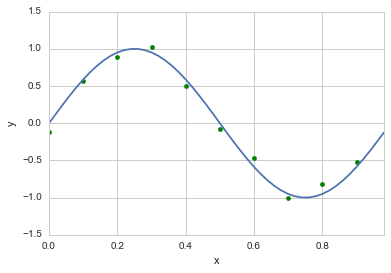

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(x_real, y_real)
ax.scatter(x_train, y_train, color='green', marker='o')
ax.set_xlim(np.min(x_real), np.max(x_real))
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')

## 正規方程式による係数ベクトルの導出

実装は http://qiita.com/antimon2/items/ac1ebaed75ad58406b94 を参考にしました

In [6]:
def poly_features(x, m):
    x_poly = np.zeros((x.size, m))
    for i in range(m):
        x_poly[:,i] = np.power(x, i+1)
    return x_poly

In [7]:
poly_features(x_train, 3)

array([[ 0.   ,  0.   ,  0.   ],
       [ 0.1  ,  0.01 ,  0.001],
       [ 0.2  ,  0.04 ,  0.008],
       [ 0.3  ,  0.09 ,  0.027],
       [ 0.4  ,  0.16 ,  0.064],
       [ 0.5  ,  0.25 ,  0.125],
       [ 0.6  ,  0.36 ,  0.216],
       [ 0.7  ,  0.49 ,  0.343],
       [ 0.8  ,  0.64 ,  0.512],
       [ 0.9  ,  0.81 ,  0.729]])

In [8]:
def normal_equation(x, y):
    return np.linalg.pinv(x.T.dot(x)).dot(x.T).dot(y)

In [9]:
w = normal_equation(poly_features(x_train, 3), y_train); w

array([  8.63708318, -25.56321269,  16.50200632])

## 線形モデルによる予測

In [10]:
def predict(w, x):
    return poly_features(x, w.size).dot(w)

In [67]:
m = 9
w = normal_equation(poly_features(x_train, m), y_train)
y_pred = predict(w, x_real)

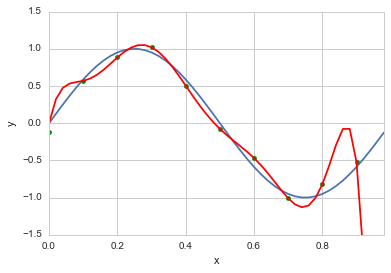

In [68]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(x_real, y_real)
ax.scatter(x_train, y_train, color='green', marker='o')
ax.plot(x_real, y_pred, color='red')
ax.set_xlim(np.min(x_real), np.max(x_real))
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')

## 正則化の導入

In [13]:
def reguralized_normal_equation(x, y, lmd):
    m = x.shape[1]
    return np.linalg.pinv(x.T.dot(x) + lmd * np.identity(m)).dot(x.T).dot(y)

In [70]:
math.exp(-25)

1.3887943864964021e-11

In [72]:
m = 9
lmd = math.exp(-25)
w = reguralized_normal_equation(poly_features(x_train, m), y_train, lmd)
y_pred = predict(w, x_real)

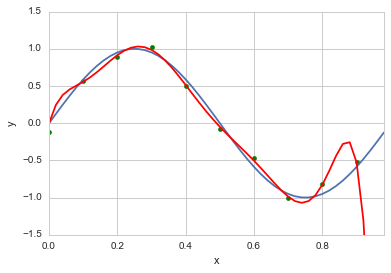

In [73]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(x_real, y_real)
ax.scatter(x_train, y_train, color='green', marker='o')
ax.plot(x_real, y_pred, color='red')
ax.set_xlim(np.min(x_real), np.max(x_real))
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')